<a href="https://colab.research.google.com/github/lucky2805/ammu/blob/master/Copy_of_CIFAR_10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#libraries
import torch
import torchvision
import torchvision.transforms as transforms
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# extracting files and fitting them as training, validation and testing data
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# assigned 40000 samples to train and 10000 to val data
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False, num_workers=8)
#test data has 10000 samples
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


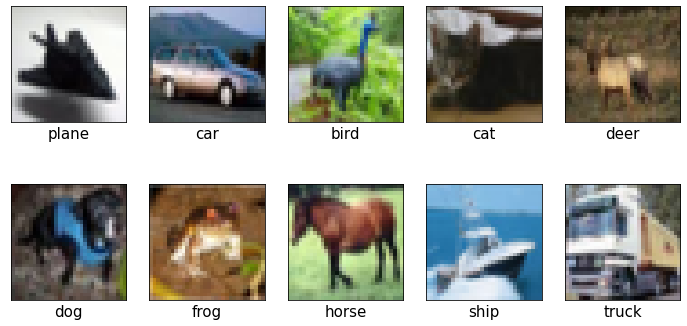

In [3]:
#visualizing image for each class
ex_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(ex_images[i])
    i += 1

In [4]:

# CNN defination
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 128, 5, padding=2)
    self.conv2 = nn.Conv2d(128, 128, 5, padding=2)
    self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
    self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.bn_conv1 = nn.BatchNorm2d(128)
    self.bn_conv2 = nn.BatchNorm2d(128)
    self.bn_conv3 = nn.BatchNorm2d(256)
    self.bn_conv4 = nn.BatchNorm2d(256)
    self.bn_dense1 = nn.BatchNorm1d(1024)
    self.bn_dense2 = nn.BatchNorm1d(512)
    self.dropout_conv = nn.Dropout2d(p=0.25)
    self.dropout = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(256 * 8 * 8, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 10)

  def conv_layers(self, x):
    out = F.relu(self.bn_conv1(self.conv1(x)))
    out = F.relu(self.bn_conv2(self.conv2(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    out = F.relu(self.bn_conv3(self.conv3(out)))
    out = F.relu(self.bn_conv4(self.conv4(out)))
    out = self.pool(out)
    out = self.dropout_conv(out)
    return out

  def dense_layers(self, x):
    out = F.relu(self.bn_dense1(self.fc1(x)))
    out = self.dropout(out)
    out = F.relu(self.bn_dense2(self.fc2(out)))
    out = self.dropout(out)
    out = self.fc3(out)
    return out

  def forward(self, x):
    out = self.conv_layers(x)
    out = out.view(-1, 256 * 8 * 8)
    out = self.dense_layers(out)
    return out

net = Net()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Device: cuda:0
Number of trainable parameters: 18617482


In [5]:

#training and validation (loss and accuracy)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_train, acc_train = [], []
loss_val, acc_val = [], []

for epoch in range(50):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # computing training accuracy
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_train.append(avg_loss)
  acc_train.append(avg_acc)

  # computing validation accuracy
  net.eval()
  with torch.no_grad():
    loss_val_1 = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val_1 += loss.item()
    avg_loss_val = loss_val_1 / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_val.append(avg_loss_val)
    acc_val.append(avg_acc_val)
  net.train()
  scheduler.step(avg_loss_val)
  print('[epoch %d] traing_loss: %.5f train_accuracy: %.4f validation_loss: %.5f validation_accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))




[epoch 1] traing_loss: 0.01421 train_accuracy: 0.3424 validation_loss: 0.01190 validation_accuracy: 0.4476
[epoch 2] traing_loss: 0.01168 train_accuracy: 0.4542 validation_loss: 0.01040 validation_accuracy: 0.5269
[epoch 3] traing_loss: 0.01037 train_accuracy: 0.5220 validation_loss: 0.00896 validation_accuracy: 0.5956
[epoch 4] traing_loss: 0.00922 train_accuracy: 0.5806 validation_loss: 0.00809 validation_accuracy: 0.6384
[epoch 5] traing_loss: 0.00826 train_accuracy: 0.6289 validation_loss: 0.00700 validation_accuracy: 0.6876
[epoch 6] traing_loss: 0.00759 train_accuracy: 0.6619 validation_loss: 0.00659 validation_accuracy: 0.7094
[epoch 7] traing_loss: 0.00709 train_accuracy: 0.6827 validation_loss: 0.00605 validation_accuracy: 0.7336
[epoch 8] traing_loss: 0.00672 train_accuracy: 0.6992 validation_loss: 0.00570 validation_accuracy: 0.7484
[epoch 9] traing_loss: 0.00644 train_accuracy: 0.7146 validation_loss: 0.00539 validation_accuracy: 0.7634
[epoch 10] traing_loss: 0.00609 train

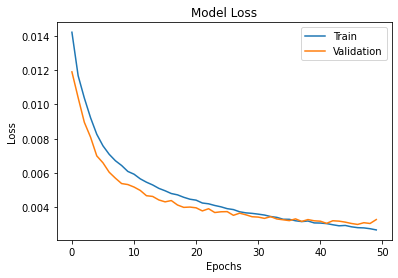

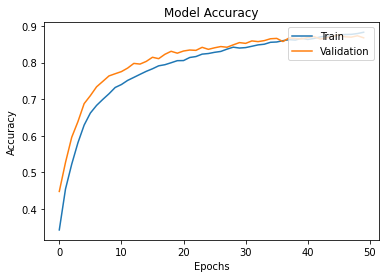

In [6]:

#plotting training statistics
legend = ['Train', 'Validation']
plt.plot(loss_train)
plt.plot(loss_val)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_train)
plt.plot(acc_val)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper right')
plt.show()

In [8]:
#saving the trained data
from google.colab import files
torch.save(net.state_dict(), 'check.pth')
# download check file
files.download('check.pth')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 50810, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

In [0]:
net.load_state_dict(torch.load('check.pth'))

In [10]:
#testing data accuracy computation
pred_v = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_v.append(predicted)
    pred_v = torch.cat(pred_v)

print('Accuracy for test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy for test images: 87.56 %


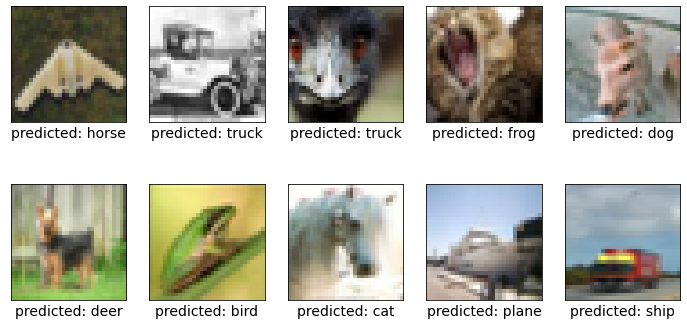

In [12]:
import numpy as np

#wrongly classified image for each class
pred_v = pred_v.cpu().numpy()
ground_truths = np.asarray(test_set.targets)
wrong_mask = pred_v != ground_truths
wrong_images = [test_set.data[(ground_truths == label) & wrong_mask][0] for label in range(10)]
pred_results = [pred_v[(ground_truths == label) & wrong_mask][0] for label in range(10)]

#images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("predicted: %s" % classes[pred_results[i]], fontsize=14)
    axis.imshow(wrong_images[i])
    i += 1